In [2]:
import numpy as np 
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
#from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from keras.models import load_model

import h5py
import requests


In [3]:
data_df =pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df2 = pd.read_csv("fundamentals.csv")
data_df = data_df[data_df.symbol == 'AAPL']


In [5]:
data_df.drop(['symbol'],axis=1,inplace=True)

In [6]:
data_df.head()

,open,close,low,high,volume
date,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0


In [7]:
data_df.shape

(1762, 5)

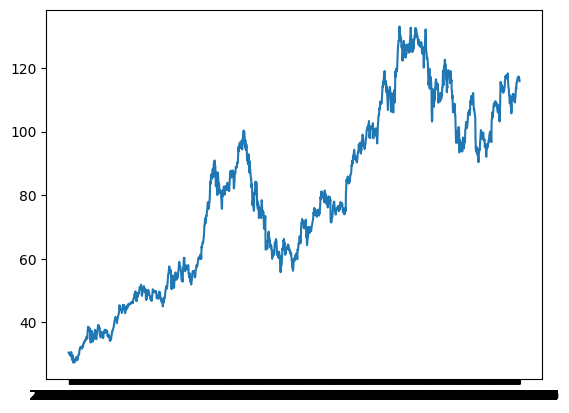

In [9]:
plt.plot(data_df['close'])
plt.show()

In [10]:
data_df['date'] = data_df.index
data_df['date'] = pd.to_datetime(data_df['date'])
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data_df['close'].values.reshape(-1, 1))
dataset[0:10]


array([[0.02971784],
       [0.03021854],
       [0.02560389],
       [0.02507612],
       [0.0269707 ],
       [0.02444008],
       [0.02120576],
       [0.02517085],
       [0.02351986],
       [0.0187834 ]])

In [11]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train,test=dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
print(len(data_df))
print(1233 + 529)


1233 529
1762
1762


In [12]:
#set the look back date as 15 days, which is the number of previous time steps to use as input variables #to predict the next time period
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [13]:
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(1217, 15)
(1217,)
(513, 15)
(513,)
(1217, 1, 15)
(1217,)
(513, 1, 15)
(513,)


In [14]:
# create and fit the LSTM network
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)





Epoch 1/20

1217/1217 - 5s - loss: 0.0058 - 5s/epoch - 4ms/step
Epoch 2/20
1217/1217 - 2s - loss: 6.6044e-04 - 2s/epoch - 2ms/step
Epoch 3/20
1217/1217 - 2s - loss: 4.8824e-04 - 2s/epoch - 2ms/step
Epoch 4/20
1217/1217 - 2s - loss: 4.2206e-04 - 2s/epoch - 2ms/step
Epoch 5/20
1217/1217 - 2s - loss: 3.8954e-04 - 2s/epoch - 2ms/step
Epoch 6/20
1217/1217 - 2s - loss: 3.7509e-04 - 2s/epoch - 2ms/step
Epoch 7/20
1217/1217 - 2s - loss: 3.3220e-04 - 2s/epoch - 2ms/step
Epoch 8/20
1217/1217 - 2s - loss: 3.3236e-04 - 2s/epoch - 2ms/step
Epoch 9/20
1217/1217 - 2s - loss: 2.9567e-04 - 2s/epoch - 2ms/step
Epoch 10/20
1217/1217 - 2s - loss: 2.7661e-04 - 2s/epoch - 2ms/step
Epoch 11/20
1217/1217 - 2s - loss: 3.0068e-04 - 2s/epoch - 2ms/step
Epoch 12/20
1217/1217 - 2s - loss: 2.5999e-04 - 2s/epoch - 2ms/step
Epoch 13/20
1217/1217 - 2s - loss: 2.5876e-04 - 2s/epoch - 2ms/step
Epoch 14/20
1217/1217 - 2s - loss: 2.4766e-04 - 2s/epoch - 2ms/step
Epoch 15/20
1217/1217 - 2s - loss: 2.3790e-04 - 2s/epoch -

In [15]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


17/17 [==============================] - 0s 2ms/step
Train Score: 1.33 RMSE
Test Score: 2.15 RMSE


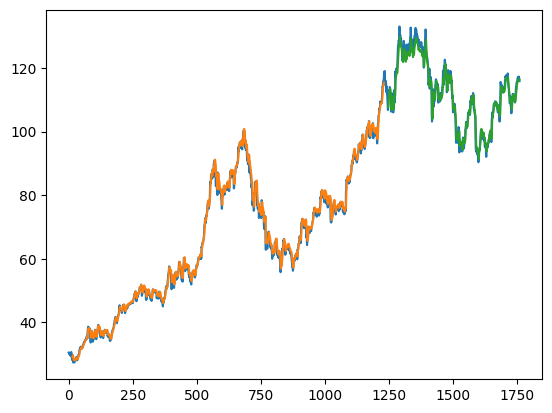

In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
